In [ ]:
from qiskit.circuit.library import QFT, QuantumVolume
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from qiskit import transpile
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph


num_qubits = 64

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5, seed=42)

# circuit = QFT(num_qubits, do_swaps=False)

# circuit = QuantumVolume(num_qubits, depth=3, seed=42)

num_partitions = 16  # Define the number of partitions or QPUs you will distribute over
depth = circuit.depth()

qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create a quantum network with the specified number of qubits and partitions

# If we do not specificy the connectivity, we have all-to-all by default.
# coupling = grid_coupling(num_partitions)
coupling = linear_coupling(num_partitions)  # Linear coupling for a linear topology
quantum_network = QuantumNetwork(qpu_sizes, coupling)

graph = QuantumCircuitHyperGraph(circuit, group_gates=True)

basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

Number of layers: 66
Number of qubits in circuit 64
Circuit depth: 64


In [ ]:
from disqco.parti.FM.fiduccia import *

FM_partitioner = FiducciaMattheyses(circuit=circuit,
                                    network=quantum_network,
                                    graph=graph
                                    )

Number of layers: 66


In [3]:
# results = FM_partitioner.partition()

# graph = FM_partitioner.hypergraph

# print(f'Best cost: {results['best_cost']}')


# if len(graph.nodes) < 500:
#     %load_ext jupyter_tikz
#     graph.draw(assignment=results['best_assignment'], qpu_info=qpu_sizes)





In [4]:
# from disqco.parti.genetic.genetic_algorithm_beta import *

# GA_partitioner = GeneticPartitioner(circuit=circuit, network=quantum_network, group_gates=True, log=True, multi_process=True)

# results = GA_partitioner.partition()
# print(f'Best cost: {results['best_cost']}')

In [5]:
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

coarsener = HypergraphCoarsener()

coarseneing_method = coarsener.coarsen_recursive_batches_mapped

results = FM_partitioner.multilevel_partition(coarsener=coarseneing_method)

Best cost at level 0: 2418
Refining assignment at level 0 of 7 with sparse=False
Best cost at level 1: 2310
Refining assignment at level 1 of 7 with sparse=False
Best cost at level 2: 2280
Refining assignment at level 2 of 7 with sparse=False
Best cost at level 3: 2217
Refining assignment at level 3 of 7 with sparse=False


KeyboardInterrupt: 

In [ ]:
print(f'Best cost: {results['best_cost']}')
print(f'Best assignment: {results["best_assignment"]}')

Best cost: 2138
Best assignment: [[ 1  3 13 ...  7  9  6]
 [ 1  3 13 ...  7  9  6]
 [ 1  3 13 ...  5  9  6]
 ...
 [10  1  9 ...  2  2  4]
 [10  0  7 ...  2  2  4]
 [10  0  6 ...  2  2  4]]


In [ ]:
# results = GA_partitioner.multilevel_partition(coarsener=coarseneing_method)

In [ ]:
# from disqco.graphs.quantum_network import linear_coupling

# coupling = linear_coupling(num_partitions)

# network = QuantumNetwork(qpu_sizes, qpu_connectivity=coupling)
# FM_partitioner = FiducciaMattheyses(circuit=circuit,
#                                     network=network)


# results = FM_partitioner.partition(log=True)

In [ ]:
# results = FM_partitioner.multilevel_partition()

In [ ]:
from disqco.parti.FM.fiduccia_ext import *
from disqco.parti.FM.FM_methods_ext import *

best_assignment = results["best_assignment"]
initial_qubit_assignment = best_assignment.transpose()

print(initial_qubit_assignment)

FM_partitioner = FiducciaMattheysesExt(circuit=circuit, network=quantum_network,initial_qubit_assignment=initial_qubit_assignment)

results = FM_partitioner.partition(passes=10, stochastic=False, log=True)



[[ 1  1  1 ... 10 10 10]
 [ 3  3  3 ...  1  0  0]
 [13 13 13 ...  9  7  6]
 ...
 [ 7  7  5 ...  2  2  2]
 [ 9  9  9 ...  2  2  2]
 [ 6  6  6 ...  4  4  4]]
Number of layers: 66
Initial cost: 972.0
Pass  0: cost = 847.0


KeyboardInterrupt: 

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


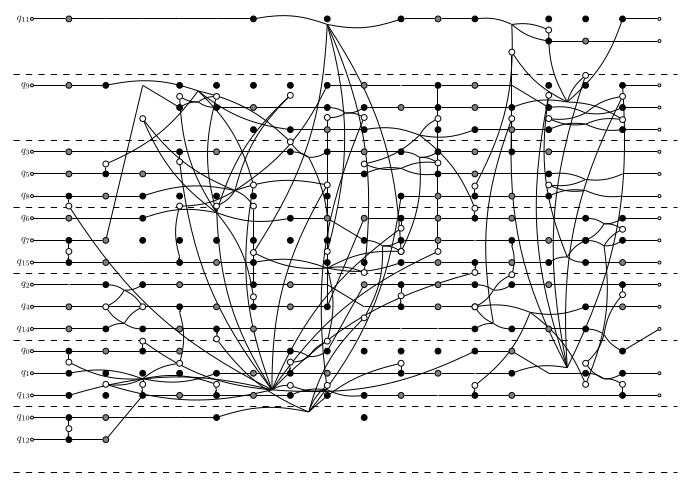

In [ ]:
graph = FM_partitioner.hypergraph
%load_ext jupyter_tikz
graph.draw(qubit_assignment=results['best_qubit_assignment'], gate_assignment=results['best_gate_assignment'],  qpu_info=qpu_sizes,show_labels=False)